# RNN을 이용한 텍스트 분류

## 설정

In [1]:
!pip install tensorflow_datasets 

In [2]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [3]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## 입력 파이프 라인 설정

In [4]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [5]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [6]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [7]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [8]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"Granted, I'm not the connoisseur d'horror my partner is, but a well put together, clever flick is worth the time. My quibbles, in brief:<br /><br />- Dialog often weak and at times unbelievable coming from the given character.<br /><br />- Unconvincing acting.<br /><br />- Storyline never really caught fire.<br /><br />The writers plucked choice bits from half a dozen mainstream films, tossed into a kettle, simmered not nearly enough and tried feeding us poor saps the resulting mess, al'dente.<br /><br />Long and short, while not absolutely terrible, it was definitely not worthy of absorbing one of my NetFlix rentals."
 b"Absolute garbage, worse fight scenes than a 20 year old van damme movie or American ninja etc.<br /><br />Truly dire acting, not a skill in sight in the entire movie its like a cast of wooden sculptures.<br /><br />Watch it just for how truly bad this film is, it may have been acceptable in the 80s but this is a 2006 movie, i don't have much love for this m

## 텍스트 인코더 생성

In [9]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [10]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [11]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  1, 142,  22, ...,   0,   0,   0],
       [  1,   1, 437, ...,   0,   0,   0],
       [ 11,  69,  28, ...,   0,   0,   0]], dtype=int64)

In [12]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"Granted, I'm not the connoisseur d'horror my partner is, but a well put together, clever flick is worth the time. My quibbles, in brief:<br /><br />- Dialog often weak and at times unbelievable coming from the given character.<br /><br />- Unconvincing acting.<br /><br />- Storyline never really caught fire.<br /><br />The writers plucked choice bits from half a dozen mainstream films, tossed into a kettle, simmered not nearly enough and tried feeding us poor saps the resulting mess, al'dente.<br /><br />Long and short, while not absolutely terrible, it was definitely not worthy of absorbing one of my NetFlix rentals."
Round-trip:  [UNK] im not the [UNK] [UNK] my [UNK] is but a well put together [UNK] flick is worth the time my [UNK] in [UNK] br dialog often weak and at times [UNK] coming from the given [UNK] br [UNK] [UNK] br storyline never really [UNK] [UNK] br the writers [UNK] [UNK] [UNK] from half a [UNK] [UNK] films [UNK] into a [UNK] [UNK] not nearly enough and tri

## 모델 생성

In [13]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [14]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [15]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[-0.00177705]


In [16]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

[-0.00177705]


In [17]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

##  모델 훈련

In [18]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 552s 1s/step - loss: 0.6632 - accuracy: 0.5292 - val_loss: 0.5333 - val_accuracy: 0.7411
Epoch 2/10
391/391 [==============================] - 545s 1s/step - loss: 0.4170 - accuracy: 0.8026 - val_loss: 0.3740 - val_accuracy: 0.8271
Epoch 3/10
391/391 [==============================] - 604s 2s/step - loss: 0.3451 - accuracy: 0.8472 - val_loss: 0.3427 - val_accuracy: 0.8573
Epoch 4/10
391/391 [==============================] - 610s 2s/step - loss: 0.3195 - accuracy: 0.8630 - val_loss: 0.3328 - val_accuracy: 0.8453
Epoch 5/10
391/391 [==============================] - 613s 2s/step - loss: 0.3115 - accuracy: 0.8672 - val_loss: 0.3309 - val_accuracy: 0.8500
Epoch 6/10
391/391 [==============================] - 606s 2s/step - loss: 0.3072 - accuracy: 0.8702 - val_loss: 0.3278 - val_accuracy: 0.8542
Epoch 7/10
391/391 [==============================] - 523s 1s/step - loss: 0.3025 - accuracy: 0.8724 - val_loss: 0.3255 - val_accuracy: 0.8562

In [19]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 52s 132ms/step - loss: 0.3202 - accuracy: 0.8642
Test Loss: 0.3202129006385803
Test Accuracy: 0.8641600012779236


(0.0, 0.6816293388605118)

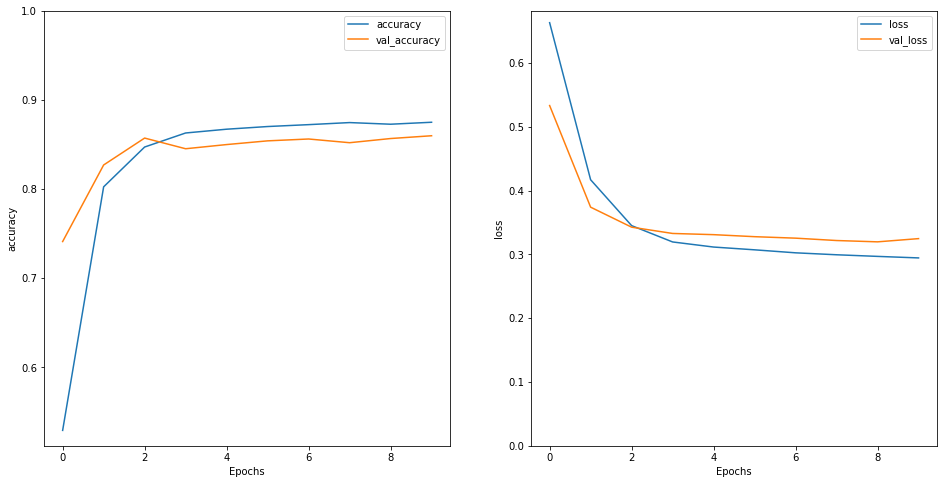

In [20]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [21]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

[[0.8061095]]


In [22]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [23]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [24]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 71s 149ms/step - loss: 0.6502 - accuracy: 0.5625 - val_loss: 0.4923 - val_accuracy: 0.7573
Epoch 2/10
391/391 [==============================] - 55s 138ms/step - loss: 0.4067 - accuracy: 0.8198 - val_loss: 0.3727 - val_accuracy: 0.8271
Epoch 3/10
391/391 [==============================] - 54s 136ms/step - loss: 0.3417 - accuracy: 0.8543 - val_loss: 0.3343 - val_accuracy: 0.8510
Epoch 4/10
391/391 [==============================] - 53s 134ms/step - loss: 0.3242 - accuracy: 0.8607 - val_loss: 0.3268 - val_accuracy: 0.8568
Epoch 5/10
391/391 [==============================] - 53s 135ms/step - loss: 0.3174 - accuracy: 0.8652 - val_loss: 0.3213 - val_accuracy: 0.8516
Epoch 6/10
391/391 [==============================] - 52s 132ms/step - loss: 0.3098 - accuracy: 0.8671 - val_loss: 0.3294 - val_accuracy: 0.8547
Epoch 7/10
391/391 [==============================] - 53s 134ms/step - loss: 0.3063 - accuracy: 0.8697 - val_loss: 0.3158 - val_ac

In [25]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 26s 65ms/step - loss: 0.3293 - accuracy: 0.8646
Test Loss: 0.329334557056427
Test Accuracy: 0.8646399974822998


In [26]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

[[-1.6796288]]


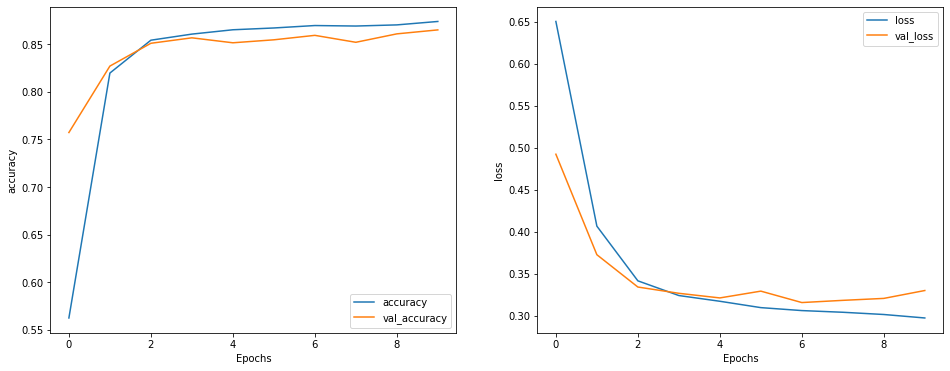

In [27]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')